# Hyperbolic Geometry Exploration

Most of the code in this notebook is strongly based on the [examples provided by Hyperbolic library](https://github.com/cduck/hyperbolic/tree/master/examples).

In [1]:
import drawsvg as draw
from drawsvg import Drawing
from hyperbolic import euclid, util
from hyperbolic.poincare import *
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import quads
import random

### Hyperbolic Line and Hyperbolic Line Segment

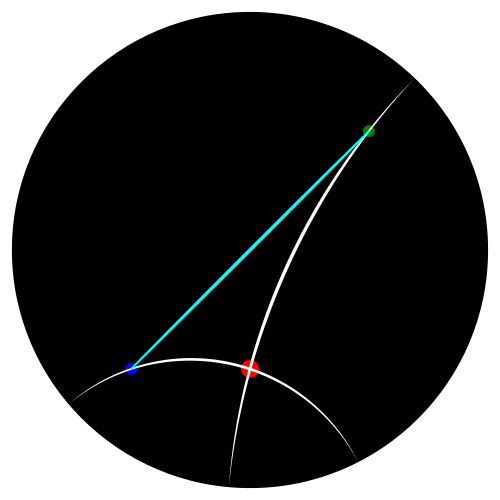

In [2]:
p1 = Point(0.0,  0.5)
p2 = Point(0.5, -0.5)
p3 = Point(-0.5, 0.5)

# Create hyperbolic line (segment) connecting p1 and p2.
# If segment==false, the hyperbolic line will extend towards
# the boundaries of the Poincaré disk.
p1p2_line = Line.from_points(*p1, *p2, segment=False)
p1p3_line = Line.from_points(*p1, *p3, segment=False)
p2p3_line = Line.from_points(*p2, *p3, segment=True)

width = height = 2.1
d = Drawing(width, height, origin='center')

# Draws a circle with center (0.0, 0.0) and radius 1.0, 
# representing the interior of the Poincaré disk.
center = (0.0, 0.0)
radius = 1.0
d.draw(euclid.Circle(*center, radius), fill='black')

# Draws points in the Poincaré disk
d.draw(p1, hradius=0.1, fill='red')
d.draw(p2, hradius=0.1, fill='green')
d.draw(p3, hradius=0.1, fill='blue')

# Draw hyperbolic line connecting p1 and p2;
# notice that the line is infinite since it
# is extended towards the boundary of the disk.
d.draw(p1p2_line, hwidth=0.03, fill='white')
d.draw(p1p3_line, hwidth=0.03, fill='white')
# Draw  hyperbolic line Segment i.e., segment
# with finite extent
d.draw(p2p3_line, hwidth=0.03, fill='cyan')

d.set_render_size(w=500)
d.save_svg('images/hyperbolic_line.svg')
d # This will render the image in the output cell

### Hyperbolic Hexagon

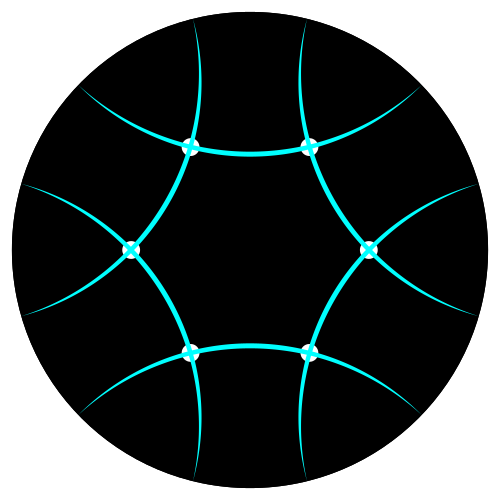

In [3]:
r = 0.5
points = []
for idx in range(6):
    angle = math.radians(idx * 60)
    points.append(Point(r * math.cos(angle), r * math.sin(angle)))

lines = []
for idx in range(6):
    start = idx % 6
    end = (idx + 1) % 6
    lines.append(Line.from_points(*points[start], *points[end], segment=False))

# Draws a circle with center (0.0, 0.0) and radius 1.0, 
# representing the interior of the Poincaré disk.
center = (0.0, 0.0)
radius = 1.0
d.draw(euclid.Circle(*center, radius), fill='black')

for point in points:
    d.draw(point, hradius=0.1, fill='white')
    
for line in lines:
    d.draw(line, hwidth=0.05, fill='cyan')

d.set_render_size(w=500)
d.save_svg('images/hyperbolic_hexagon.svg')
d # This will render the image in the output cell

### Euclidean Quadtree

In [4]:
# Domain centered at the origin and in range [-1; 1]
tree = quads.QuadTree((0, 0), 2.0, 2.0)

# Generate points inside Poincaré disk
points = []
num_points = 100

while len(points) != num_points:
    x = random.uniform(-1.0, 1.0)
    y = random.uniform(-1.0, 1.0)
    
    # Test if point is inside Poincaré disk,
    # but not on the boundary.
    if x**2 + y**2 < 1.0:
        points.append((x, y))
        tree.insert((x, y))

points = np.array(points)
start = quads.BoundingBox(min_x=-1, min_y=-1, max_x=1, max_y=1)
# Lib seems to be broken? Center of box from (-1, -1) to (1, 1) should be (0, 0)?
#print(start.center) # Returns (1.0, 1.0), but should be (0, 0) ?
# self.center = Point(self.half_width, self.half_height)

def bbox_center(bounding_box):
    return quads.Point((bounding_box.max_x + bounding_box.min_x) / 2, (bounding_box.max_y + bounding_box.min_y) / 2)

#print(bbox_center(start)) # Seems correct?

def split(parent) -> list:    
    #center = parent.center # Seems to be broken?
    center = bbox_center(parent)
    
    return [ 
        # Upper-Right Node
        quads.BoundingBox(min_x=center.x, min_y=center.y,
                      max_x=center.x + parent.half_width, max_y=center.y + parent.half_height),
        # Upper-Left Node
        quads.BoundingBox(min_x=center.x - parent.half_width, min_y=center.y,
                      max_x=center.x, max_y=center.y + parent.half_height),
        # Lower-Left Node
        quads.BoundingBox(min_x=center.x - parent.half_width, min_y=center.y - parent.half_height,
                      max_x=center.x, max_y=center.y),
        # Lower-Right Node TODO
        quads.BoundingBox(min_x=center.x, min_y=center.y - parent.half_height,
                      max_x=center.x + parent.half_width, max_y=center.y),
    ]
            

split(start)

[<BoundingBox: (0.0, 0.0) to (1.0, 1.0)>,
 <BoundingBox: (-1.0, 0.0) to (0.0, 1.0)>,
 <BoundingBox: (-1.0, -1.0) to (0.0, 0.0)>,
 <BoundingBox: (0.0, -1.0) to (1.0, 0.0)>]

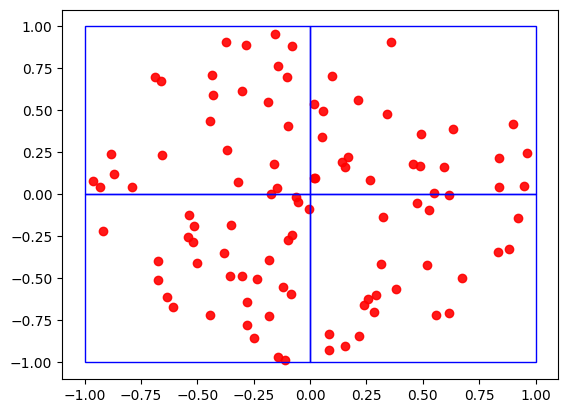

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    x=[points[:, 0]],
    y=[points[:, 1]],
    marker='o', alpha=0.9, color='red')

for children in split(start):
    ax.add_patch(
        patches.Rectangle(
            xy=(children.min_x, children.min_y),
            width=children.width, height=children.height, linewidth=1,
            color='blue', fill=False))

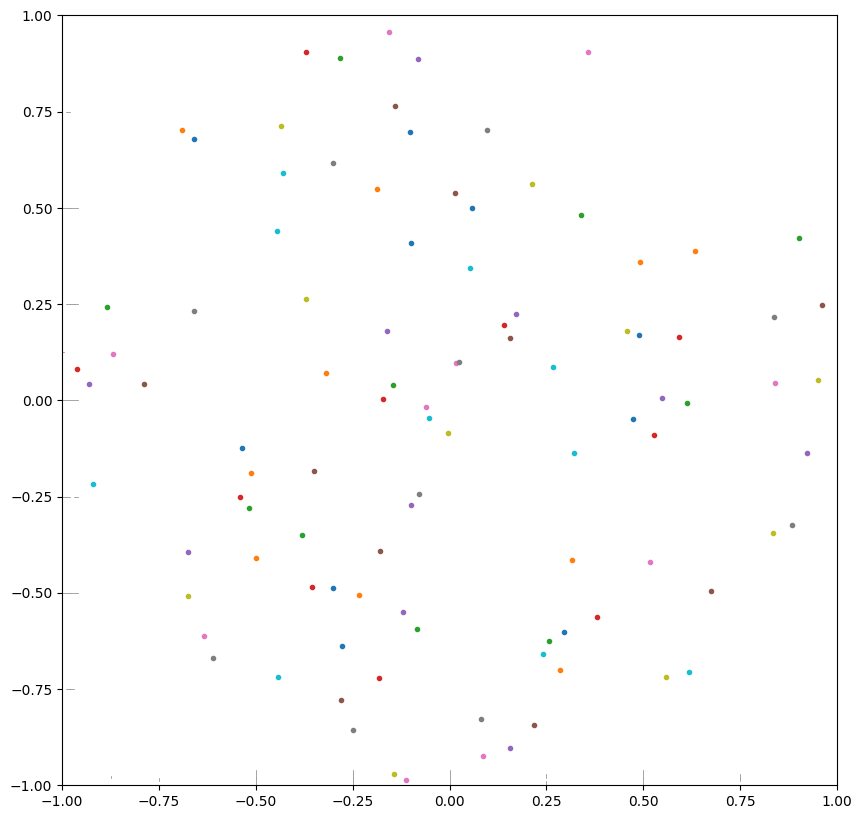

In [6]:
quads.visualize(tree)

### Polar Quadtree (Equal Area Splitting)

In [7]:
def cartesian_to_polar(points):
    """
    Args
        points: ndarray containing points in Cartesian coordinates.
    
    Returns
        ndarray: points in polar coordinates, where the first column is the
        radius and the second column is the angle (in radians).
    """
    assert points.shape[1] == 2
    return np.column_stack((np.sqrt(points[:, 0]**2 + points[:, 1]**2), np.arctan2(points[:, 1], points[:, 0])))

polar_points = cartesian_to_polar(points)
assert points.shape == polar_points.shape

In [8]:
np.max(polar_points[:, 0])

0.9954707502688883

In [9]:
def polar_equal_area_split(min_r, max_r, min_theta, max_theta, alfa=1.0):
    """
    Args
        min_r, max_r (float): polar radius range of current node
        min_theta, max_theta (float): angles (in radians) range of the current node
    
    Returns
        (float, float): equal area split of radius and angle.
    """
    return (np.arccosh((np.cosh(alfa * max_r) + np.cosh(alfa * min_r)) / 2.0) * (1.0 / alfa), (min_theta + max_theta) / 2)

0.7190795463117667 3.141592653589793
0.5156524289400033 1.5707963267948966
0.3692353662713848 0.7853981633974483
0.26551856551732406 0.39269908169872414
0.19316154062961613 0.19634954084936207
0.14369452304646554 0.09817477042468103
0.11090141775020353 0.04908738521234052
0.09011255207108847 0.02454369260617026
0.7190795463117667 3.141592653589793
0.5156524289400033 1.5707963267948966
0.3692353662713848 0.7853981633974483
0.26551856551732406 0.39269908169872414
0.19316154062961613 0.19634954084936207
0.14369452304646554 0.09817477042468103
0.11090141775020353 0.04908738521234052
0.09011255207108847 0.02454369260617026


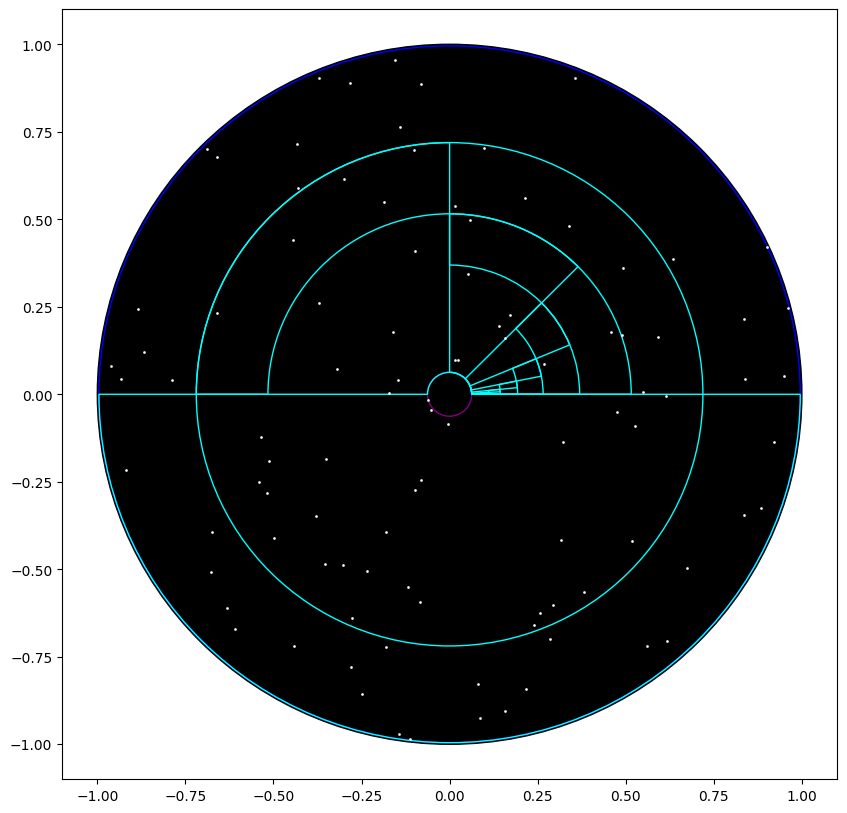

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Draw Poincaré disk
poincare_boundary = plt.Circle((0, 0), 1.0, color='black')
#inner_circle = plt.Circle((0, 0), np.min(polar_points[:, 0]), facecolor='red', edgecolor='purple')
inner_circle = plt.Circle((0, 0), np.min(polar_points[:, 0]), color='purple', fill=False)
outer_circle = plt.Circle((0, 0), np.max(polar_points[:, 0]), color='blue', fill=False)

# Angles in **degrees**; draws a wedge starting at r-width and ending at r, ranging from theta1 to theta2
#wedge = patches.Wedge((0, 0), r=0.5, theta1=30, theta2=60, width=0.2, color='cyan', fill=False)
#ax.add_patch(wedge)
ax.add_patch(poincare_boundary)
ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

# NOTE: better to keep all calculations in radians and *only* convert it to
# degrees when it is time to display the result using patches.Wed
# TODO: refactor the following into a separate class storing PolarNodes
min_r, max_r, min_theta, max_theta = np.min(polar_points[:, 0]), np.max(polar_points[:, 0]), 0.0, 2 * np.pi
for _ in range(8):
    mid_r, mid_theta = polar_equal_area_split(min_r, max_r, 0.0, max_theta)
    print(mid_r, mid_theta)
    wedge = patches.Wedge((0, 0), r=max_r, theta1=np.degrees(mid_theta), theta2=np.degrees(max_theta), width=(max_r - mid_r), color='cyan', fill=False)
    ax.add_patch(wedge)
    
    max_r = mid_r
    max_theta = mid_theta

min_r, max_r, min_theta, max_theta = np.min(polar_points[:, 0]), np.max(polar_points[:, 0]), 0.0, 2 * np.pi
for _ in range(8):
    mid_r, mid_theta = polar_equal_area_split(min_r, max_r, 0.0, max_theta)
    print(mid_r, mid_theta)
    wedge = patches.Wedge((0, 0), r=mid_r, theta1=0, theta2=np.degrees(mid_theta), width=(mid_r - min_r), color='cyan', fill=False)
    ax.add_patch(wedge)
    
    max_r = mid_r
    max_theta = mid_theta
    
ax.scatter(
    x=[points[:, 0]],
    y=[points[:, 1]],
    marker='o', alpha=0.9, color='white', s=1.0)